<a href="https://colab.research.google.com/github/varamba/Ya_practicum_projects/blob/main/project_final_ab_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Введение
Необходимо провести оценку результатов A/B-теста. В распоряжении есть датасет с действиями пользователей, техническое задание и несколько вспомогательных датасетов.
- Оценить корректность проведения теста.
- Проанализировать результаты теста.
- Проверить: пересечение тестовой аудитории с конкурирующим тестом;
    совпадение теста и маркетинговых событий, другие проблемы временных границ теста.

## Техническое задание
Название теста: recommender_system_test;<div>
Группы: А (контрольная), B (новая платёжная воронка);<div>
Дата запуска: 2020-12-07;<div>
Дата остановки набора новых пользователей: 2020-12-21;<div>
Дата остановки: 2021-01-04;<div>
Аудитория: 15% новых пользователей из региона EU;<div>
Назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;<div>
Ожидаемое количество участников теста: 6000.<div>
Ожидаемый эффект: за 14 дней с момента регистрации в системе пользователи покажут улучшение каждой метрики не менее, чем на 10%:
конверсии в просмотр карточек товаров — событие product_page<div>
просмотры корзины — product_cart<div>
покупки — purchase.

## Цели/Задачи
Предобработка:<div>
    
- Проверить, требуется ли преобразование типов?
- Найти пропуски, дупликаты, объяснить их.
- Оценить корректность проведения теста.<div>
- Проверить соответствие данных требованиям технического задания.<div>
- Проверить корректность всех пунктов технического задания.<div>
- Проверить время проведения теста.<div>
- Убедиться, что оно не совпадает с маркетинговыми и другими активностями.<div>
- Обратить внимание на аудиторию теста.<div>
- Удостоверьться, что нет пересечений с конкурирующим тестом и нет пользователей, участвующих в двух группах теста одновременно.<div>
- Проверить равномерность распределения пользователей по тестовым группам и правильность их формирования.<div>
    
Исследовательский анализ данных:<div>
- Количество событий на пользователя одинаково распределены в выборках?<div>
- Как число событий в выборках распределено по дням?<div>
- Как меняется конверсия в воронке в выборках на разных этапах?<div>
- Какие особенности данных нужно учесть, прежде чем приступать к A/B-тестированию?<div>
    
Оценка результатов A/B-тестирования:<div>
- Что можно сказать про результаты A/B-тестирования?<div>
- Проверить статистическую разницу долей z-критерием.<div>
- Сделать выводы

## Предобработка

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import math as mth
import numpy as np
from scipy import stats as st
import datetime as dt
from datetime import timedelta
from plotly import graph_objects as go
import plotly.express as px
import re
from pandas.plotting import register_matplotlib_converters
import warnings 
warnings.filterwarnings("ignore")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
try:
  m_events, new_users, events, participants = (
      pd.read_csv('https://code.s3.yandex.net/datasets/ab_project_marketing_events.csv', sep=',', engine = 'python'),
      pd.read_csv('https://code.s3.yandex.net/datasets/final_ab_new_users.csv', sep=',', engine = 'python'),
      pd.read_csv('https://code.s3.yandex.net/datasets/final_ab_events.csv', sep=',', engine = 'python'),
      pd.read_csv('https://code.s3.yandex.net/datasets/final_ab_participants.csv', sep=',', engine = 'python'))
except:
  m_events, new_users, events, participants = (
      pd.read_csv('/dataframes/ab_project_marketing_events.csv', sep=',', engine = 'python'),
      pd.read_csv('/dataframes/final_ab_new_users.csv', sep=',', engine = 'python'),
      pd.read_csv('/dataframes/final_ab_events.csv', sep=',', engine = 'python'),
      pd.read_csv('/dataframes/final_ab_participants.csv', sep=',', engine = 'python'))

In [4]:
tabs = [m_events, new_users, events, participants]
for t in tabs:
    display(t.head())
    display(t.info())
    display(t.isna().mean())
    display(t.duplicated().sum())

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes


None

name         0.0
regions      0.0
start_dt     0.0
finish_dt    0.0
dtype: float64

0

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB


None

user_id       0.0
first_date    0.0
region        0.0
device        0.0
dtype: float64

0

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB


None

user_id       0.000000
event_dt      0.000000
event_name    0.000000
details       0.857512
dtype: float64

0

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB


None

user_id    0.0
group      0.0
ab_test    0.0
dtype: float64

0

In [5]:
m_events['start_dt'] = pd.to_datetime(m_events['start_dt']).dt.date
m_events['finish_dt'] = pd.to_datetime(m_events['finish_dt']).dt.date

new_users['first_date'] = pd.to_datetime(new_users['first_date']).dt.date

events['event_dt'] = pd.to_datetime(events['event_dt'])
events['date'] = events['event_dt'].dt.date

In [6]:
for t in tabs:
    display(t.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     440317 non-null  object        
 1   event_dt    440317 non-null  datetime64[ns]
 2   event_name  440317 non-null  object        
 3   details     62740 non-null   float64       
 4   date        440317 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 16.8+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB


None

In [7]:
events['event_name'].unique()

array(['purchase', 'product_cart', 'product_page', 'login'], dtype=object)

In [8]:
events.query('details.isna() == True')['event_name'].unique()

array(['product_cart', 'product_page', 'login'], dtype=object)

**Подитог:** дупликатов нет, даты - даты, пропусков нет, кроме details в events, которые показывают стоимость покупки и присутствуют только в событии purchase.

Подготовлю общую таблицу.

In [9]:
df = pd.merge(new_users, participants, on = 'user_id',how='outer')
df

,user_id,first_date,region,device,group,ab_test
0,D72A72121175D8BE,2020-12-07,EU,PC,A,recommender_system_test
1,F1C668619DFE6E65,2020-12-07,N.America,Android,NaN,NaN
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC,A,interface_eu_test
3,50734A22C0C63768,2020-12-07,EU,iPhone,B,interface_eu_test
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone,NaN,NaN
...,...,...,...,...,...,...
63330,1DB53B933257165D,2020-12-20,EU,Android,NaN,NaN
63331,538643EB4527ED03,2020-12-20,EU,Mac,NaN,NaN
63332,7ADEE837D5D8CBBD,2020-12-20,EU,PC,NaN,NaN
63333,1C7D23927835213F,2020-12-20,EU,iPhone,B,interface_eu_test


Удалим пользователей, не участвовших в тесте.

In [10]:
df = df.dropna(subset=['ab_test'])

Посмотрим на период проведения теста.

In [11]:
#df['first_date'].agg({'min','max'})

In [12]:
df.query('ab_test == "recommender_system_test"')['first_date'].agg({'min','max'})

min    2020-12-07
max    2020-12-21
Name: first_date, dtype: object

In [13]:
df = df.rename(columns = {'first_date':'dt'})
df['dt'] = pd.to_datetime(df['dt'])
#df.head()

По ТЗ дата начала: 2020-12-07, а окончания: 2020-12-21.

In [14]:
df = df.query('dt >= "2020-12-07" & dt <= "2020-12-21"')
df.head()

,user_id,dt,region,device,group,ab_test
0,D72A72121175D8BE,2020-12-07,EU,PC,A,recommender_system_test
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC,A,interface_eu_test
3,50734A22C0C63768,2020-12-07,EU,iPhone,B,interface_eu_test
13,E6DE857AFBDC6102,2020-12-07,EU,PC,B,recommender_system_test
14,E6DE857AFBDC6102,2020-12-07,EU,PC,B,interface_eu_test


Найдем ребят, попавших в оба теста.

In [15]:
df.groupby('user_id').agg({'group' : 'nunique'}).query('group>1').count()

group    776
dtype: int64

Количество пользователей в тесте интерфеса

In [16]:
i_e_test = df.query('ab_test == "interface_eu_test"')['user_id'].nunique()
i_e_test

10565

Количество пользователей в рекомендованном тесте

In [17]:
r_s_test = df.query('ab_test == "recommender_system_test"')['user_id'].nunique()
r_s_test

6701

Всего пользователей

In [18]:
users_cnt_sum = i_e_test+r_s_test
users_cnt_sum

17266

In [19]:
#check
df['user_id'].nunique()

15664

Разница:

In [20]:
users_cnt_sum - df['user_id'].nunique()

1602

Или можно сделать вот так, как я сделал изначально, просто не учел тесты, а считал по группам:

In [21]:
df.groupby('user_id').agg({'ab_test' : 'nunique'}).query('ab_test>1').count()

ab_test    1602
dtype: int64

Удалим двойных агентов.

In [22]:
two_tests_users = df.groupby('user_id').agg({'ab_test' : 'nunique'}).reset_index().query('ab_test>1')['user_id'].unique()

In [23]:
df = df.query('user_id not in @two_tests_users')

In [24]:
ab_users = df.groupby('user_id').agg({'group' : 'nunique'}).reset_index().query('group>1')['user_id'].unique()
df = df.query('user_id not in @ab_users')

Проверяю:

In [25]:
df_rec = df.query('ab_test == "recommender_system_test"')

Группа А

In [26]:
df_rec.query('group == "A"')['user_id'].nunique()

2903

Группа В

In [27]:
df_rec.query('group == "B"')['user_id'].nunique()

2196

Всего:

In [28]:
df_rec['user_id'].nunique()

5099

Разница

In [29]:
df_rec['user_id'].nunique() - df_rec.query('group == "A"')['user_id'].nunique() - df_rec.query('group == "B"')['user_id'].nunique()

0

Или так:

In [30]:
#df_rec = df.query('ab_test == "recommender_system_test"')
#display(df_rec)
df_rec.groupby('user_id').agg({'group' : 'nunique'}).query('group>1').count()

group    0
dtype: int64

Не нашлось таких ребят

Далее Считаем прибывших европейцев:

In [31]:
new_eu_users = df.query('region == "EU" & ab_test == "recommender_system_test"')['user_id'].nunique()
new_eu_users

4749

Всего пользователей за период:

In [32]:
new_users['first_date'] = pd.to_datetime(new_users['first_date'])
users_cnt = new_users.query('region == "EU" & first_date >= "2020-12-07" & first_date <= "2020-12-21"')['user_id'].nunique()
users_cnt

42340

Считаем % евро-ребят:

In [33]:
new_eu_users/users_cnt*100

11.216343882853094

Итого: 11.2% Европейцев - до 15% не дотянули.

Проверим пересечение с рекламными ивентами:

In [34]:
m_events['start_dt'] = pd.to_datetime(m_events['start_dt'])
m_events['finish_dt'] = pd.to_datetime(m_events['finish_dt'])
display(m_events)
#m_events.info()
display(m_events.query('start_dt > "2020-12-07" | finish_dt <= "2020-01-04"'))

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11


,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
10,CIS New Year Gift Lottery,CIS,2020-12-30,2021-01-07


Отсюда видим, что есть 2 события пересекающие период теста, одно событие из влияющее на регион Содружество Независимых Государств - несильно помешает тесту, в второе может оказать влияние, нужно будет обратить внимание на период дат с 25декабря по 3 января в блоке распределения событий.

Продолжаем выделять нужных нам ребят.

In [35]:
ab_df = df.query('ab_test == "recommender_system_test"')
#ab_df.head()

Получилось 5099 юзеров, опять же не дотянули до ожидаемых 6к пользователей.

In [36]:
# users_group = ab_df.groupby('group')['user_id'].count().reset_index()
# users_group

In [37]:
# df = px.data.tips()
# fig = px.pie(users_group, values='user_id', names='group', title='Соотношение пользователей в группах')
# fig.show()

Итог: данные для теста изначально собраны с ошибками, конфликтующие даты, пользователи из разных тестов, разве что ивенты маркетологов не повлияли на результат.<div>
Имеем 5099 юзеров, из них 2903 - контрольная группа, 2196 - новая платежная воронка.

Делаю еще одну мегатабличку.

In [38]:
data = pd.merge(events, ab_df, on = 'user_id',how='outer')
data = data.dropna(subset=['ab_test'])
data

,user_id,event_dt,event_name,details,date,dt,region,device,group,ab_test
44,831887FE7F2D6CBA,2020-12-07 06:50:29,purchase,4.99,2020-12-07,2020-12-07,EU,Android,A,recommender_system_test
45,831887FE7F2D6CBA,2020-12-09 02:19:17,purchase,99.99,2020-12-09,2020-12-07,EU,Android,A,recommender_system_test
46,831887FE7F2D6CBA,2020-12-07 06:50:30,product_cart,NaN,2020-12-07,2020-12-07,EU,Android,A,recommender_system_test
47,831887FE7F2D6CBA,2020-12-08 10:52:27,product_cart,NaN,2020-12-08,2020-12-07,EU,Android,A,recommender_system_test
48,831887FE7F2D6CBA,2020-12-09 02:19:17,product_cart,NaN,2020-12-09,2020-12-07,EU,Android,A,recommender_system_test
...,...,...,...,...,...,...,...,...,...,...
442623,7EA72BCB46012967,NaT,NaN,NaN,NaN,2020-12-20,EU,iPhone,B,recommender_system_test
442624,1942FB76074AA16F,NaT,NaN,NaN,NaN,2020-12-20,EU,PC,B,recommender_system_test
442625,6670B7F8E44E51A9,NaT,NaN,NaN,NaN,2020-12-20,EU,Android,B,recommender_system_test
442626,FB99C8676FAF89A7,NaT,NaN,NaN,NaN,2020-12-20,EU,PC,B,recommender_system_test


Считаю лайфтайм и отсекаю лишних

In [39]:
data['date'] = pd.to_datetime(data['date'])
data['lf_days'] = data['date'] - data['dt']
data.head()

,user_id,event_dt,event_name,details,date,dt,region,device,group,ab_test,lf_days
44,831887FE7F2D6CBA,2020-12-07 06:50:29,purchase,4.99,2020-12-07,2020-12-07,EU,Android,A,recommender_system_test,0 days
45,831887FE7F2D6CBA,2020-12-09 02:19:17,purchase,99.99,2020-12-09,2020-12-07,EU,Android,A,recommender_system_test,2 days
46,831887FE7F2D6CBA,2020-12-07 06:50:30,product_cart,NaN,2020-12-07,2020-12-07,EU,Android,A,recommender_system_test,0 days
47,831887FE7F2D6CBA,2020-12-08 10:52:27,product_cart,NaN,2020-12-08,2020-12-07,EU,Android,A,recommender_system_test,1 days
48,831887FE7F2D6CBA,2020-12-09 02:19:17,product_cart,NaN,2020-12-09,2020-12-07,EU,Android,A,recommender_system_test,2 days


In [40]:
# data = data.query('lf_days <= "14 days"')
data = data.loc[data['lf_days']<='14 days']
data.sample(5)

,user_id,event_dt,event_name,details,date,dt,region,device,group,ab_test,lf_days
380993,6CB864E93DBC6A90,2020-12-20 20:07:01,product_page,NaN,2020-12-20,2020-12-19,APAC,Android,A,recommender_system_test,1 days
416434,E785E40D0C268712,2020-12-09 20:47:31,login,NaN,2020-12-09,2020-12-09,EU,Android,A,recommender_system_test,0 days
137250,40AD302D0F49AA6F,2020-12-19 17:08:57,product_page,NaN,2020-12-19,2020-12-19,EU,Mac,A,recommender_system_test,0 days
274574,FF825C1D791989B5,2020-12-19 19:29:18,login,NaN,2020-12-19,2020-12-19,EU,PC,A,recommender_system_test,0 days
124193,A57DB8C0438CB846,2020-12-19 21:33:09,login,NaN,2020-12-19,2020-12-17,EU,iPhone,B,recommender_system_test,2 days


Смотрю распределение групп.

In [41]:
users_group = data.groupby(['group'])['user_id'].nunique().reset_index()
users_group

,group,user_id
0,A,2082
1,B,706


In [42]:
fig = px.pie(users_group, values='user_id', names='group', title='Соотношение пользователей в группах')
fig.show()

**Вывод:** Данные собраны плохо, много пересечений пользователей, группы разделились не попровну, количество пользователей сильно меньше ожидаемых 6000.

## Исследовательский анализ

Смотрим распределение событий по времени.

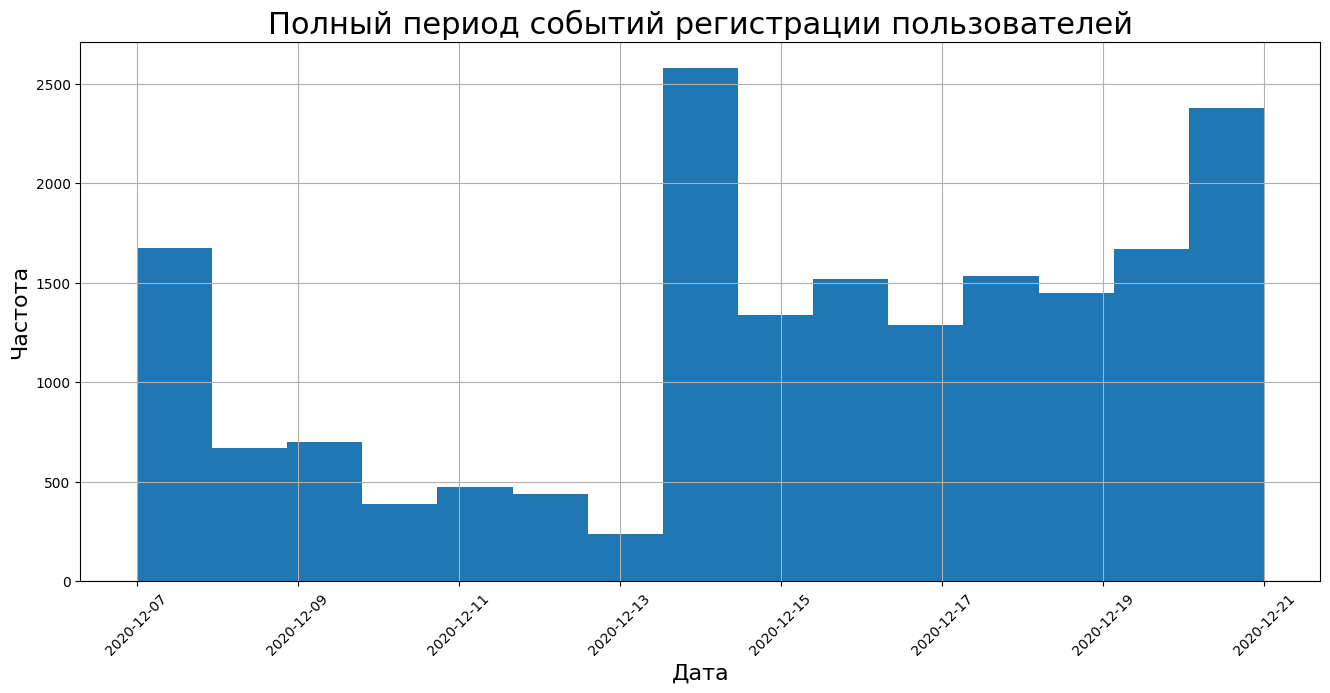

In [43]:
plt.figure(figsize=(16,7))
ax = data['dt'].hist(bins = 15)
plt.title('Полный период событий регистрации пользователей', fontsize=22)
plt.ylabel("Частота", fontsize=16)
plt.xlabel("Дата", fontsize=16)
plt.xticks(rotation=45)
plt.show()

14 декабря наблюдается скачек регистраций. Не могу сказать с чем это связано, маркетологовых событий в этот момент не было. Возможно косяк с получением данных от датаинженеров. Либо просто потому что так сложилось и много людей зарегалось в этот день

Строю воронку событий.

In [44]:
# events_ab = pd.merge(events, participants, on = 'user_id',how='outer')
# events_ab = events_ab.dropna(subset=['ab_test','event_name']).query('ab_test == "recommender_system_test"')
# events_ab = events_ab[['user_id', 'event_name','details','date', 'group']]
# events_ab.head()

In [45]:
funnel = data[['user_id', 'event_name','details','date', 'group']]
funnel.sample(5)

,user_id,event_name,details,date,group
199307,115EBC1CA027854A,login,NaN,2020-12-14,B
219882,E923C28598AD9E74,product_cart,NaN,2020-12-18,B
109078,5D0230BA5C402C36,product_cart,NaN,2020-12-25,A
389636,DFFC60C5AD11418C,product_page,NaN,2020-12-20,A
214240,AF24276134C433DE,product_cart,NaN,2020-12-17,A


In [46]:
funnel['event_name'].unique()

array(['purchase', 'product_cart', 'login', 'product_page'], dtype=object)

In [47]:
#funnel = funnel.query('event_name != "login"')

In [48]:
funnel_grouped = funnel.groupby(['group','event_name'])['user_id'].nunique().reset_index().rename(columns={'event_name':'event','user_id': 'users'})
funnel_grouped

,group,event,users
0,A,login,2082
1,A,product_cart,631
2,A,product_page,1360
3,A,purchase,652
4,B,login,705
5,B,product_cart,195
6,B,product_page,397
7,B,purchase,198


In [49]:
def sorter(column):
    reorder = [
        "login",
        "product_page",
        "product_cart",
        "purchase"]
    cat = pd.Categorical(column, categories=reorder, ordered=True)
    return pd.Series(cat)

In [50]:
funnel_A = funnel_grouped.query('group == "A"').reset_index().sort_values(by="event", key=sorter)
funnel_A

,index,group,event,users
0,0,A,login,2082
2,2,A,product_page,1360
1,1,A,product_cart,631
3,3,A,purchase,652


In [51]:
funnel_B = funnel_grouped.query('group == "B"').reset_index().sort_values(by="event", key=sorter)
funnel_B

,index,group,event,users
0,4,B,login,705
2,6,B,product_page,397
1,5,B,product_cart,195
3,7,B,purchase,198


In [52]:
fig = go.Figure()

fig.add_trace(go.Funnel(
    name = 'Group A',
    y = funnel_A['event'],
    x = funnel_A['users'],
    textinfo = "value+percent initial"))

fig.add_trace(go.Funnel(
    name = 'Group B',
    orientation = "h",
    y = funnel_B['event'],
    x = funnel_B['users'],
    textposition = "inside",
    textinfo = "value+percent initial"))
fig.update_layout(
    title="Воронка событий")

fig.show()

Воронка событий:<div>
1 - логин пользователя в системе
2 - карточка товара<div>
3 - просмотр корзины<div>
4 - покупка<div>
НО, исходя из данных делаю вывод, что покупка возможна и без перехода в корзину а.к.а. быстрая оплата из карточки товара.
    
На 2м шаге отваливается около 45% пользователей.

Распределены количество событий на пользователя:

In [53]:
data.query('group == "A"').groupby(['user_id'])['event_name'].count().mean()

6.944764649375601

In [54]:
data.query('group == "B"').groupby(['user_id'])['event_name'].count().mean()

5.481586402266289

В группе А пользователь совершает больше действий, нежели в группе В.

In [55]:
#events_ab.head()

In [56]:
event_by_day = funnel.groupby(['group','date'])['event_name'].count().reset_index()
event_by_day.head()

,group,date,event_name
0,A,2020-12-07,234
1,A,2020-12-08,267
2,A,2020-12-09,296
3,A,2020-12-10,265
4,A,2020-12-11,282


In [57]:
fig = px.bar(event_by_day, x="date", y='event_name', color = 'group',text = 'event_name', title="Количество событий по дням", \
             labels={'date':'Дата','event_name':'Кол-во'})
fig.show()

21 числа наблюдается всплеск событий. Не уверен почему.

(В чате подсказалали, что возможно из-за рождества 25 числа у европейцев и они покупают подарки, сам не додумался)

Учитывая событие от маркетологов в период от 12-25 по 01-03 - сильного влияния не замечено, наоборот в эти даты наблюдается спад по событиям.

Вспомогательная таблица для z-теста:

In [58]:
event_gr = funnel.pivot_table(index='event_name', columns='group', values='user_id', aggfunc='nunique', margins = True).reset_index().sort_values(by="event_name", key=sorter).reset_index(drop=True)
event_gr

group,event_name,A,B,All
0,login,2082,705,2787
1,product_page,1360,397,1757
2,product_cart,631,195,826
3,purchase,652,198,850
4,All,2082,706,2788


Использую свою функцию для множественного z-теста из сборного проекта№2 (думаю так можно делать)

In [59]:
def check_metrics(df, i, g1, g2,j): 
    alpha = 0.01
    u1 = df.loc[i][g1]
    u2 = df.loc[i][g2]
    e1 = df.loc[j][g1]
    e2 = df.loc[j][g2]

    # пропорция успехов в первой группе:
    p1 = u1 / e1
    # пропорция успехов во второй группе
    p2 = u2 / e2
    
    print(u1, u2, e1, e2)
    
    # пропорция успехов в комбинированном датасете
    p_c = (u1 + u2) / (e1 + e2) 
    
    # разница пропорций в датасетах
    diff = p1 - p2
    
    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = diff / mth.sqrt(p_c * (1 - p_c) * (1 / e1 + 1 / e2))
    
    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    # введем поправку Бонферрони, поделим альфа на число гипотез для всех проверок
    bonferroni_alpha = alpha / 4
    
    print('Проверка для групп А и В, событие: {}, p-значение: {p_value:.2f}'.format(df.loc[i][j-4], p_value=p_value))
    if (p_value < bonferroni_alpha):
        print("Отвергаем нулевую гипотезу о равенстве данных в группах")
    else:
        print("Не получилось отвергнуть нулевую гипотезу о равенстве данных в группах")

Гипотеза:

Н0: доли уникальных посетителей, находящихся в группах А и В, побывавших на этапе воронки, одинаковы.

Н1: доли уникальных посетителей, побывавших на этапе воронки, различаются.

In [60]:
for event in range(len(event_gr.index[:-1])):
    check_metrics(event_gr,event,1,2,4)

2082 705 2082 706
Проверка для групп А и В, событие: login, p-значение: 0.09
Не получилось отвергнуть нулевую гипотезу о равенстве данных в группах
1360 397 2082 706
Проверка для групп А и В, событие: product_page, p-значение: 0.00
Отвергаем нулевую гипотезу о равенстве данных в группах
631 195 2082 706
Проверка для групп А и В, событие: product_cart, p-значение: 0.18
Не получилось отвергнуть нулевую гипотезу о равенстве данных в группах
652 198 2082 706
Проверка для групп А и В, событие: purchase, p-значение: 0.10
Не получилось отвергнуть нулевую гипотезу о равенстве данных в группах


**Вывод:** Нет статистически значимой разницы для событий между группами.

Разве что пользователи обеих групп в разных долях доходят до шага просмотра товара.

## Вывод

В ходе задания был проведен анализ А/В поведения пользователей.

При обработке данных была проведена предобработка данных, в которой было отсечено большое количество данных, не подходживших под критерии теста: отсечены даты, отделены пользователи по региону и типу теста.
В тесте были такие показатели(в актуальном временном периоде):

Было 2788 уникальных юзеров, из них 2082 - контрольная группа, 706 - новая платежная воронка.

Далее была определена воронка событий, до последнего шага которой доходит 28% пользователей, а больше всего отваливается на 2м шаге - примерно 40%, при этом шаг предварительного просмотра покупок можно пропустить, что повлияло на шаг покупки - он больше ем просмотр корзины.

Далее был проведен анализ теста:
- При проверке статистических гипотез уровень значимости альфа был 1%;
- Так как было преведено 3 сравнения, то была сделана поправка Бонферрони;
- По результатам теста статистически значимой разницы на основных шагах между группами выявлено не было;
- однако пользователи обеих групп в разных долях доходят до шага просмотра товара;

Рекомендации по проведению теста: увеличить количество людей в группе В, увеличить влияние в Евро-регионе, возможно стоит увеличить период для набора людей.

Скорее всего нужно перезапустить тест, с новыми данными.